<a href="https://colab.research.google.com/github/plaban1981/Fastai/blob/master/Fastai_NLP_Mental_Health_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *

In [4]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/Zindi/Tech4MentalHealth/Train.csv')
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [5]:
labels = pd.get_dummies(train['label'])

In [6]:
train = pd.concat([train,labels],axis=1)
train.head()

,ID,text,label,Alcohol,Depression,Drugs,Suicide
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,0,1,0,0
1,9JDAGUV3,Why do I get hallucinations?,Drugs,0,0,1,0
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,0,1,0,0
3,6UY7DX6Q,Why is life important?,Suicide,0,0,0,1
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,0,1,0,0


In [7]:
train = train.drop(['ID','label'],axis=1)

In [8]:
train.head()

,text,Alcohol,Depression,Drugs,Suicide
0,I feel that it was better I dieAm happy,0,1,0,0
1,Why do I get hallucinations?,0,0,1,0
2,I am stresseed due to lack of financial suppor...,0,1,0,0
3,Why is life important?,0,0,0,1
4,How could I be helped to go through the depres...,0,1,0,0


## Use TextHero to preprocess the text

In [13]:
#pip install texthero
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_stopwords,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_digits]
train['clean_text'] = hero.clean(train['text'], custom_pipeline)

In [14]:
train.head()

,text,Alcohol,Depression,Drugs,Suicide,clean_text
0,I feel that it was better I dieAm happy,0,1,0,0,feel better dieam happy
1,Why do I get hallucinations?,0,0,1,0,get hallucinations
2,I am stresseed due to lack of financial suppor...,0,1,0,0,stresseed due lack financial support school
3,Why is life important?,0,0,0,1,life important
4,How could I be helped to go through the depres...,0,1,0,0,could helped go depression


In [15]:
new_train = train.drop('text',axis=1)

In [16]:
new_train.head()

,Alcohol,Depression,Drugs,Suicide,clean_text
0,0,1,0,0,feel better dieam happy
1,0,0,1,0,get hallucinations
2,0,1,0,0,stresseed due lack financial support school
3,0,0,0,1,life important
4,0,1,0,0,could helped go depression


In [18]:
data =(TextList.from_df(new_train,cols='clean_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch(bs=32))

In [19]:
data.show_batch()

idx,text
0,unworthy xxunk cope stress xxunk past xxbos xxunk help stop weed addiction xxbos feel bad life xxunk xxunk feel bad one control xxbos effects smoking bhang xxbos xxunk feeling xxunk xxbos cope xxunk xxunk situation avoid xxbos xxunk xxunk xxunk xxbos could stop using bhang xxbos avoid drug xxunk xxbos feel xxunk xxbos right depressed person use drugs xxbos xxunk taking alcohol xxunk good xxbos seek help alcoholism xxbos xxunk
1,challenges depression xxunk effects health xxbos feel xxunk helpless xxunk xxunk xxunk better xxbos one avoid bad company xxbos xxunk depression xxunk xxbos effects alcohol xxbos feel xxunk unwanted xxbos xxunk situation xxbos much xxunk cope xxunk many xxunk xxbos stop alcohol xxbos xxunk lot challenges life financially xxunk xxunk solutions xxunk xxunk solutions depression xxunk xxbos sad lonely xxbos feel unworthy wasted xxbos best ways xxunk stop using xxbos
2,handle drink xxbos feel depressed relationship issues xxbos stop taking alcohol xxbos xxunk alcoholism xxbos effects alcohol xxbos xxunk xxunk money xxunk xxbos xxunk xxbos xxunk help xxunk thoughts xxbos get help xxbos could xxunk depression xxbos xxunk depression xxunk think best way avoid xxunk xxunk xxbos lonely xxunk xxbos xxunk alcohol xxbos feel xxunk xxunk xxbos xxunk ways reduce depression xxbos feel low xxbos xxunk xxunk xxunk depression xxbos
3,alcohol xxunk health xxbos bad company friends xxunk smoke weed xxbos self worth life xxbos low self esteem xxbos overcome alcoholism xxbos xxunk overcome feeling xxbos stop alcohol xxbos stop drinking alcohol xxbos overcome xxunk xxbos xxunk effects problems xxunk depression xxbos best way xxunk drugs xxbos feelings xxunk xxunk feelings xxunk xxbos effects depression xxbos xxunk take overcome suicidal thoughts xxbos avoid getting addicted xxbos feeling xxunk feel better
4,use bhang xxbos xxunk xxunk xxunk stress xxbos feelings xxunk better xxbos xxunk avoid xxunk exams xxbos xxunk xxunk xxunk xxbos overcome peer pressure taking alcohol xxbos handle xxunk xxbos xxunk stop alcohol xxunk xxbos manage xxunk drinking xxbos life xxunk xxbos sad xxbos xxunk xxunk xxunk xxunk xxunk feeling much better xxbos feel xxunk fine xxbos xxunk xxunk xxunk xxunk xxbos xxunk taking bhang xxbos xxunk xxbos feel xxunk


In [20]:
learn = language_model_learner(data,AWD_LSTM,drop_mult=0.7)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


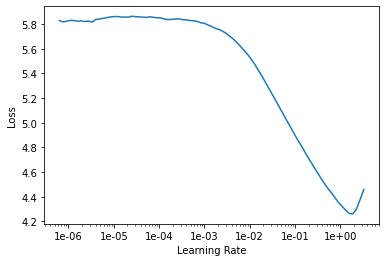

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.857212,4.888231,0.153571,00:11
1,5.702623,4.229262,0.223661,00:11
2,5.449790,3.833545,0.302679,00:11
3,5.184345,3.654145,0.302679,00:11
4,4.976697,3.614640,0.298661,00:11


In [26]:
learn.save_encoder('stage-1')

In [27]:
label_cols = ['Alcohol','Depression','Drugs','Suicide']

In [29]:
test = pd.read_csv('/content/drive/My Drive/Zindi/Tech4MentalHealth/Test.csv')

In [30]:
test.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [31]:
test = test.drop('ID',axis=1)

In [32]:
test['clean_text'] = hero.clean(test['text'], custom_pipeline)

In [33]:
test_dataset = TextList.from_df(test,cols='clean_text',vocab=data.vocab)

In [35]:
data_clas = (TextList.from_df(train,cols='clean_text',vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols=label_cols,classes=label_cols)
             .add_test(test_dataset)
             .databunch(bs=32))

In [37]:
data_clas.show_batch()

text,target
xxbos xxunk lot challenges life financially xxunk xxunk solutions xxunk xxunk solutions depression xxunk,Depression
xxbos avoid xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk issues,Depression
xxbos feel like xxunk xxunk everything xxunk feel like things xxunk,Depression
xxbos feel depressed issues best xxunk xxunk xxunk xxunk xxunk xxunk,Depression
xxbos xxunk xxunk low sad xxunk feel better xxunk xxunk,Depression


# Classifier

In [38]:
learn_classifier = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)
learn_classifier.load_encoder('stage-1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (493 items)
x: TextList
xxbos feel better xxunk xxunk,xxbos get xxunk,xxbos xxunk xxunk lack financial support school,xxbos life xxunk,xxbos could xxunk xxunk depression
y: MultiCategoryList
Depression,Drugs,Depression,Suicide,Depression
Path: .;

Valid: LabelList (123 items)
x: TextList
xxbos xxunk feel like xxunk worth xxunk,xxbos xxunk without money,xxbos people xxunk xxunk xxunk everything,xxbos lack financial support relationship xxunk,xxbos feel xxunk sad
y: MultiCategoryList
Depression,Depression,Depression,Depression,Depression
Path: .;

Test: LabelList (309 items)
x: TextList
xxbos overcome bad feelings xxunk,xxbos feel like giving life,xxbos depressed feel like xxunk xxunk xxunk,xxbos feel low xxunk xxunk one talk,xxbos xxunk drug addict
y: EmptyLabelList
,,,,
Path: ., model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(152, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropo

In [39]:
learn_classifier.freeze()
learn_classifier.lr_find()

epoch,train_loss,valid_loss,time
0,0.755222,#na#,00:04
1,0.753772,#na#,00:04
2,0.746814,#na#,00:04
3,0.704715,#na#,00:04
4,0.628276,#na#,00:03
5,0.639655,#na#,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


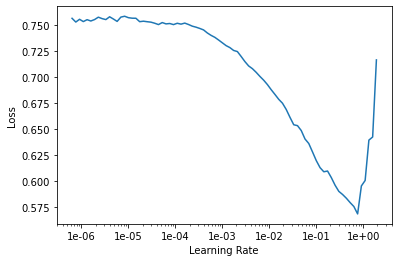

In [40]:
learn_classifier.recorder.plot()

In [43]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.303758,0.246733,00:05


In [44]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6 **4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.305291,0.322813,00:06


In [45]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6 **4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.299191,0.293542,00:10


In [47]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.247656,0.257435,00:14
1,0.231081,0.264525,00:13
2,0.217584,0.218800,00:13
3,0.205380,0.270170,00:13
4,0.191652,0.221471,00:13
5,0.179203,0.189663,00:13
6,0.168453,0.178992,00:13
7,0.151677,0.186576,00:14
8,0.138129,0.189152,00:13
9,0.129925,0.189081,00:13


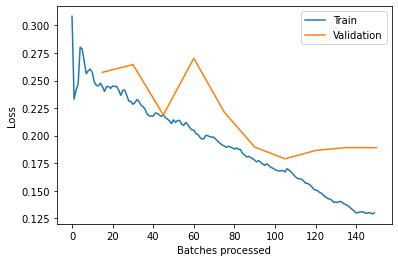

In [48]:
learn_classifier.recorder.plot_losses()

In [62]:
interp = ClassificationInterpretation.from_learner(learn_classifier)

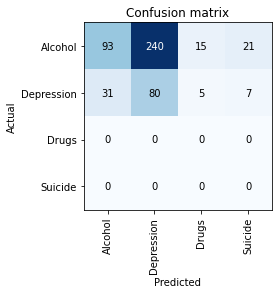

In [67]:
interp.plot_confusion_matrix()

In [69]:
accuracy(preds, y)

NameError: ignored

In [49]:
def precision(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()

In [50]:

def recall(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

# Predictions

In [51]:
preds,targets = learn_classifier.get_preds(DatasetType.Test,ordered=True)
labels =preds.numpy()                               

In [52]:
labels

array([[0.102755, 0.423838, 0.02601 , 0.358321],
       [0.014931, 0.971086, 0.012713, 0.016883],
       [0.009907, 0.982278, 0.008899, 0.012757],
       [0.005122, 0.992603, 0.007062, 0.006798],
       ...,
       [0.06625 , 0.752858, 0.063773, 0.123895],
       [0.08963 , 0.320949, 0.033862, 0.529706],
       [0.075846, 0.25159 , 0.673378, 0.024766],
       [0.096288, 0.594462, 0.04471 , 0.166274]], dtype=float32)

In [56]:
results = pd.DataFrame(labels,columns=label_cols)

In [57]:
results.head()

,Alcohol,Depression,Drugs,Suicide
0,0.102755,0.423838,0.026010,0.358321
1,0.014931,0.971086,0.012713,0.016883
2,0.009907,0.982278,0.008899,0.012757
3,0.005122,0.992603,0.007062,0.006798
4,0.049938,0.020787,0.973470,0.012394


In [58]:
test = pd.read_csv('/content/drive/My Drive/Zindi/Tech4MentalHealth/Test.csv')
df_results = pd.concat([test,results],axis=1)

In [59]:
df_results.head()

,ID,text,Alcohol,Depression,Drugs,Suicide
0,02V56KMO,How to overcome bad feelings and emotions,0.102755,0.423838,0.026010,0.358321
1,03BMGTOK,I feel like giving up in life,0.014931,0.971086,0.012713,0.016883
2,03LZVFM6,I was so depressed feel like got no strength t...,0.009907,0.982278,0.008899,0.012757
3,0EPULUM5,I feel so low especially since I had no one to...,0.005122,0.992603,0.007062,0.006798
4,0GM4C5GD,can i be successful when I am a drug addict?,0.049938,0.020787,0.973470,0.012394


In [61]:
df_results.tail(20)

,ID,text,Alcohol,Depression,Drugs,Suicide
289,XUHRT8P4,I don't see the need to live in the world,0.059041,0.580095,0.034295,0.491538
290,XXMTEUX8,How do I go about solving my problem?,0.058189,0.883398,0.031497,0.022449
291,XYRTMPGC,I feel depressed because of lack of school fee...,0.000804,0.999105,0.001202,0.000527
292,Y3QTMIO7,Dumped with my boyfriend?,0.066250,0.752858,0.063773,0.123895
293,Y5S49JQ7,Asked for financial support from wellwishers,0.041809,0.868377,0.114461,0.014954
294,YAK9NY3K,how can I limit my drinking,0.871097,0.107075,0.033859,0.029782
295,YCHHQT18,"If a person rejects you, what would you do?",0.110229,0.113882,0.136896,0.726439
296,YDIWQZA5,Is suicide the right decision?,0.111710,0.246047,0.062996,0.538569
297,YG9CPVR0,What can i do to pass at school? what can i do...,0.079002,0.788685,0.045832,0.060770
298,YIJ0CEQJ,What are the effects of abusing bhang?,0.076494,0.117543,0.815320,0.016316
